In [1]:
import os

try:
    snakemake
except NameError:
    from snakemk_util import load_rule_args
    
    os.chdir('../..')
    
    snakemake = load_rule_args(
        snakefile = os.getcwd() + "/workflow/Snakefile",
        rule_name = 'differential_apa_c2c12',
        root = '..',
    )

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from lapa.result import LapaResult

sns.set_context('poster')

In [3]:
result = LapaResult(snakemake.input['long_read'])

In [4]:
df = pd.read_csv(snakemake.input['stats'])

In [5]:
df

,polya_site,odds_ratio,pval,delta_usage,gene_id,pval_adj,gene_name,gene_type
0,chr10:100443912:-,0.000000,2.942635e-08,-0.747475,ENSMUSG00000036676.14,1.763512e-07,Tmtc3,protein_coding
1,chr10:100572273:-,1.924752,5.553080e-02,0.106953,ENSMUSG00000046567.10,9.760826e-02,4930430F08Rik,protein_coding
2,chr10:100572334:-,0.519547,5.553080e-02,-0.106953,ENSMUSG00000046567.10,9.760826e-02,4930430F08Rik,protein_coding
3,chr10:105763195:-,0.827586,6.780249e-01,-0.028737,ENSMUSG00000036009.16,7.694059e-01,Mettl25,protein_coding
4,chr10:105763253:-,1.208333,6.780249e-01,0.028737,ENSMUSG00000036009.16,7.694059e-01,Mettl25,protein_coding
...,...,...,...,...,...,...,...,...
6815,chrX:98948881:+,0.589008,1.328580e-01,-0.083358,ENSMUSG00000047694.12,2.049981e-01,Yipf6,protein_coding
6816,chrX:98948966:+,1.166667,8.132951e-01,0.012125,ENSMUSG00000047694.12,8.888106e-01,Yipf6,protein_coding
6817,chrX:98949010:+,1.254920,6.686501e-01,0.023269,ENSMUSG00000047694.12,7.620645e-01,Yipf6,protein_coding
6818,chrX:99465767:-,0.440969,1.107138e-07,-0.118844,ENSMUSG00000034403.16,6.138767e-07,Pja1,protein_coding


In [6]:
df[df['gene_name'] == 'Fstl1']

,polya_site,odds_ratio,pval,delta_usage,gene_id,pval_adj,gene_name,gene_type
2051,chr16:37835743:+,4.237502,2.989810e-156,0.306322,ENSMUSG00000022816.11,1.073185e-153,Fstl1,protein_coding
2052,chr16:37836493:+,0.235988,2.989810e-156,-0.306322,ENSMUSG00000022816.11,1.073185e-153,Fstl1,protein_coding


In [7]:
df['-log10(p-value corrected)'] = -np.log10(df['pval_adj'])
df.loc[df['-log10(p-value corrected)'] == np.inf, '-log10(p-value corrected)'] = 300

/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [8]:
df = df.loc[df.groupby('gene_id')['pval_adj'].idxmin()]

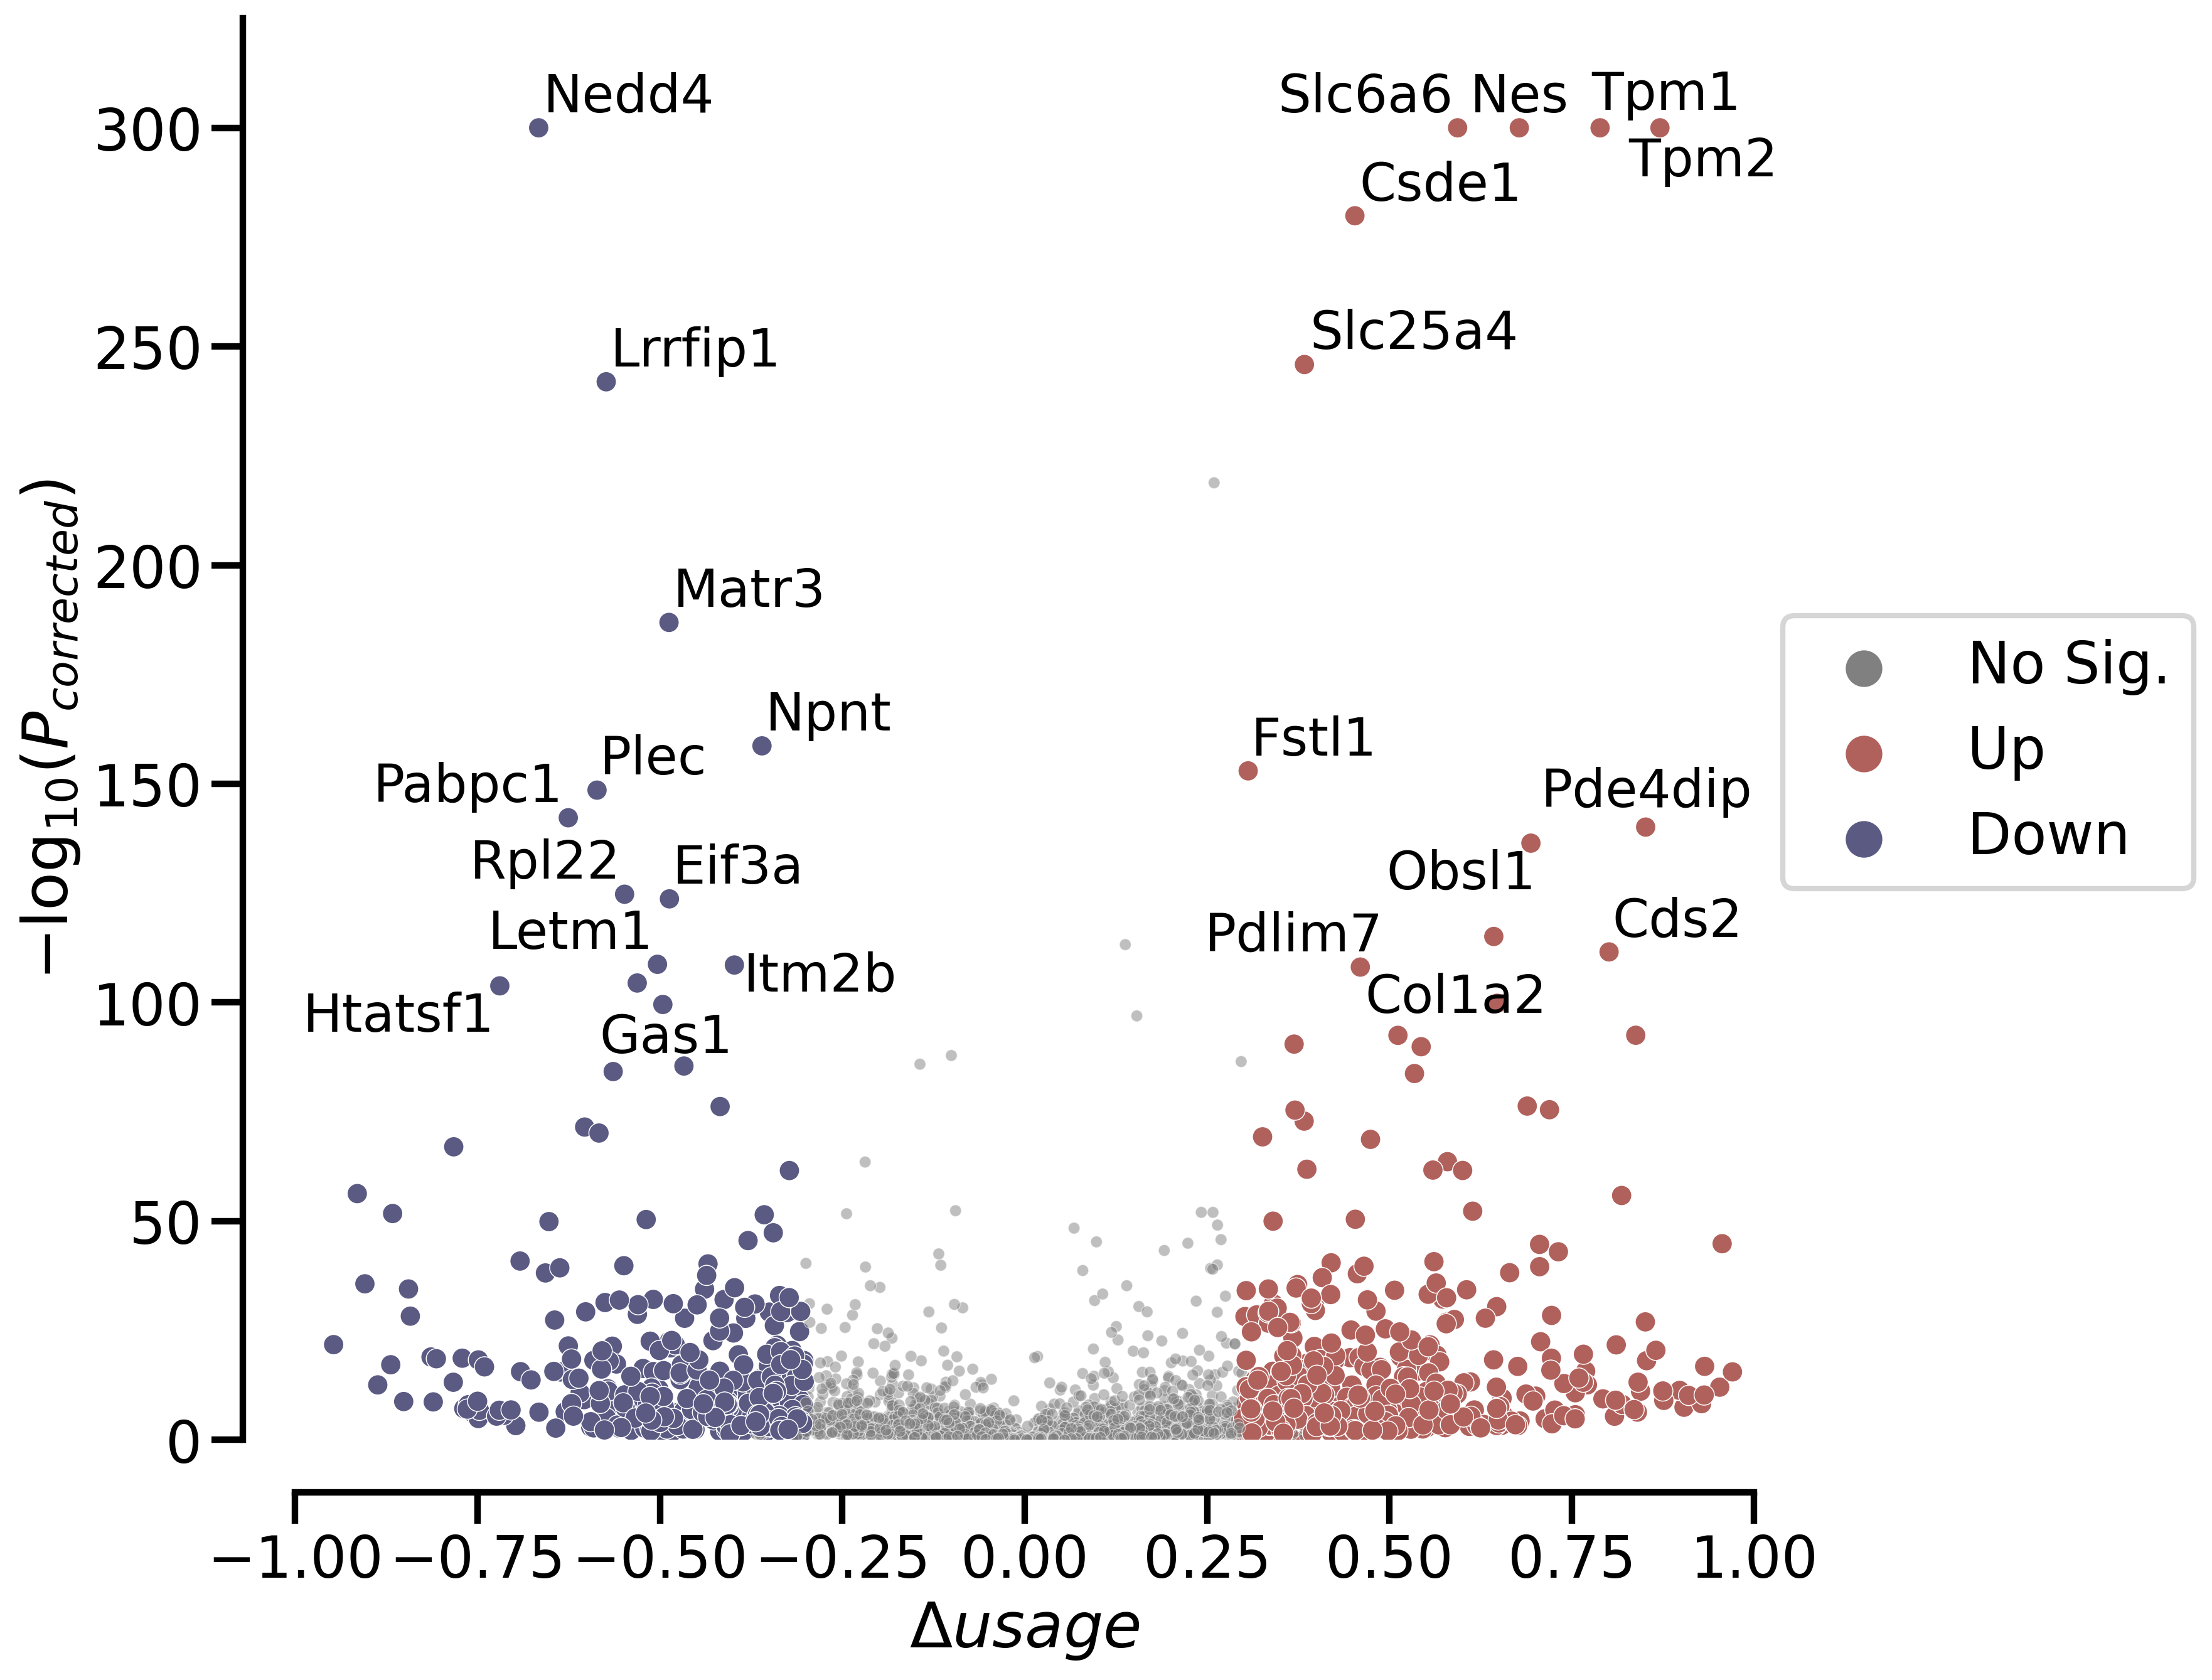

In [9]:
from adjustText import adjust_text

df['significant'] = np.where(
    (df['delta_usage'].abs() > 0.3) & (df['pval_adj'] < 0.05),
    np.where(df['delta_usage'] > 0.3, 'Up', 'Down'),
    'No Sig.'
)

plt.figure(dpi=300, figsize=(10, 10))

sns.scatterplot(data=df, x='delta_usage', y='-log10(p-value corrected)', hue='significant',
                s = 40 * (df['significant'] != 'No Sig.') + 20, 
                palette = ['gray', '#b1615c', '#5a5a83'], 
                alpha = list(0.5 + (df['significant'] != 'No Sig.') * 0.5))

plt.legend(title=None, bbox_to_anchor=(1, 0.6))
plt.xlabel('$\Delta usage$')
plt.ylabel('$-\log_{10}(P_{corrected})$')

_df = df[(df['delta_usage'].abs() > 0.3) & (df['-log10(p-value corrected)'] > 100)]

text = [
    plt.text(row['delta_usage'], row['-log10(p-value corrected)'], row['gene_name'], fontsize=20)
    for _, row in _df.iterrows()
]
adjust_text(text)
sns.despine(offset=20, trim=False)

plt.xlim(-1, 1)
plt.ylim(0, 325)

plt.savefig(snakemake.output['volcona_plot'], dpi=400, bbox_inches='tight', transparent=True)

In [10]:
df = df[(df['pval_adj'] < 0.05) & (df['delta_usage'].abs() > 0.3)]

In [11]:
df.sort_values('delta_usage')

,polya_site,odds_ratio,pval,delta_usage,gene_id,pval_adj,gene_name,gene_type,-log10(p-value corrected),significant
3422,chr2:113746162:-,0.0,7.483168e-24,-0.947350,ENSMUSG00000074934.3,1.630518e-22,Grem1,protein_coding,21.787674,Down
3491,chr2:126791567:-,0.0,6.246487e-59,-0.914933,ENSMUSG00000027365.14,4.841028e-57,Trpm7,protein_coding,56.315062,Down
5594,chr7:112355186:+,0.0,4.655446e-38,-0.904491,ENSMUSG00000038244.14,2.048396e-36,Mical2,protein_coding,35.688586,Down
4894,chr5:124568973:+,0.0,2.335661e-14,-0.886859,ENSMUSG00000029389.17,2.637286e-13,Ddx55,protein_coding,12.578843,Down
3141,chr1:189876691:+,0.0,3.988106e-19,-0.869048,ENSMUSG00000026604.17,6.506910e-18,Ptpn14,protein_coding,17.186625,Down
...,...,...,...,...,...,...,...,...,...,...
1823,chr15:76658141:-,inf,6.109438e-12,0.931440,ENSMUSG00000053929.17,5.489640e-11,Cyhr1,protein_coding,10.260456,Up
1101,chr12:83660678:+,inf,9.746530e-19,0.932072,ENSMUSG00000010608.15,1.531598e-17,Rbm25,protein_coding,16.814855,Up
4743,chr4:72118210:-,inf,8.129096e-14,0.952742,ENSMUSG00000008305.18,8.758363e-13,Tle1,protein_coding,12.057577,Up
863,chr11:97777525:-,inf,2.308845e-47,0.956065,ENSMUSG00000071415.6,1.381257e-45,Rpl23,protein_coding,44.859726,Up


In [12]:
usage = result.attribute('usage').loc[df['polya_site']][[
    'ENCFF772LYG', 'ENCFF421MIL', 'ENCFF699KOR', 'ENCFF731HHB']]

In [13]:
colors = ['#5a5a83', '#7d7da5', '#9696c0', '#b8b8d5', '#dbd0db', '#e9c6c6', '#e0a29e', '#d3827d', '#b1615c']
col_colors = ['#c08e39', '#022a2a']

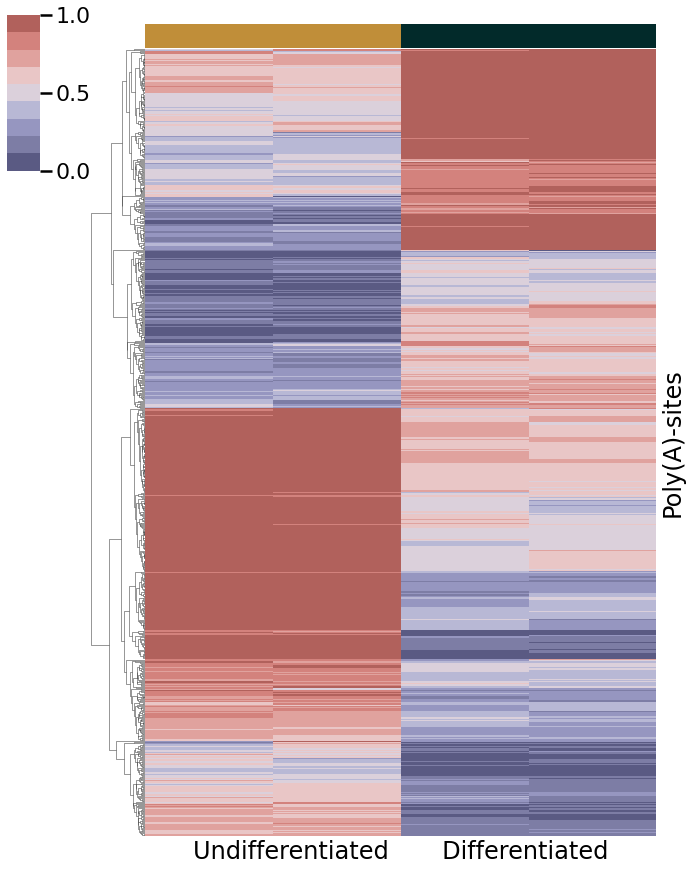

In [14]:
import seaborn as sns
import matplotlib.patches as mpatches


fig = sns.clustermap(usage.fillna(0), figsize=(9, 12),
                     col_colors=[col_colors[0], col_colors[0], col_colors[1], col_colors[1]],
                     xticklabels=False, yticklabels=False, col_cluster=False,
                     cmap=sns.color_palette(colors, as_cmap=True), 
                     cbar_pos=(-0.085, 0.8, 0.05, 0.18), dendrogram_ratio=(0.1, 0))

fig.ax_heatmap.set_xlabel('Undifferentiated' + ' ' * 7 +'Differentiated')
fig.ax_heatmap.set_ylabel('Poly(A)-sites')

plt.savefig(snakemake.output['heatmap_plot'], dpi=400, bbox_inches='tight', transparent=True)